In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os

In [96]:
current_dir = os.getcwd()
datapath = os.path.join(current_dir, "../..", 'data/outputs/DES_data.csv')

df = pd.read_csv(datapath, sep=',', index_col='date')
df.index = pd.to_datetime(df.index)
print(df.head())

                     PVSim-0.PV_0-P[MW]  CSV-0.DNI_0-DNI  \
date                                                       
2022-01-01 00:00:00                 0.0           -0.991   
2022-01-01 00:15:00                 0.0           -1.000   
2022-01-01 00:30:00                 0.0           -0.996   
2022-01-01 00:45:00                 0.0           -0.989   
2022-01-01 01:00:00                 0.0           -0.976   

                     CSV-1.HEATLOAD_0-T_amb  HeatPumpSim-0.HeatPump_0-T_amb  \
date                                                                          
2022-01-01 00:00:00                   6.855                           0.000   
2022-01-01 00:15:00                   6.460                           6.855   
2022-01-01 00:30:00                   6.205                           6.460   
2022-01-01 00:45:00                   6.100                           6.205   
2022-01-01 01:00:00                   6.100                           6.100   

                     CSV-

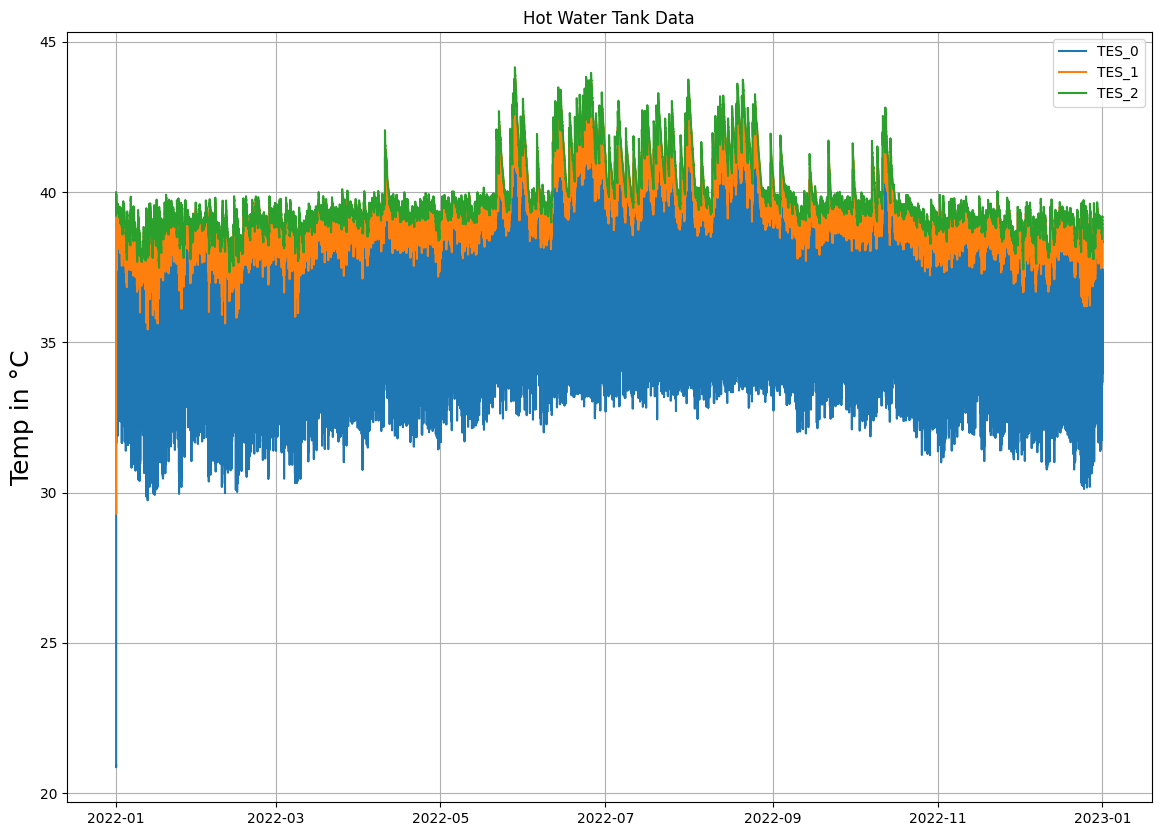

In [97]:
hot_water_tank_columns = [col for col in df.columns if col.startswith('HotWaterTankSim-0.HotWaterTank_0-sensor')] # hwts1


plt.figure(figsize=(14, 10))
plt.plot(df[hot_water_tank_columns], label=['TES_0', 'TES_1', 'TES_2'])
# plt.plot(df['HotWaterTankSim-0.HotWaterTank_0-hp_out.T'], color='orange')
# 
# plt.plot(df['CHPSim-0.CHP_0-temp_out'], color='red', label='CHP out temp')
# plt.plot(df['HotWaterTankSim-0.HotWaterTank_0-hp_in.T'], color='blue', label='HP output')
# plt.plot(df['HeatPumpSim-0.HeatPump_0-heat_source_T'], color='red', label='heat source temp')
# plt.plot(df['ControllerSim-0.Controller_0-dhw_in_T'], color='red', label='DHW in T')
plt.ylabel('Temp in °C', fontsize=18)
plt.title('Hot Water Tank Data')
plt.grid()
plt.legend()
plt.show()

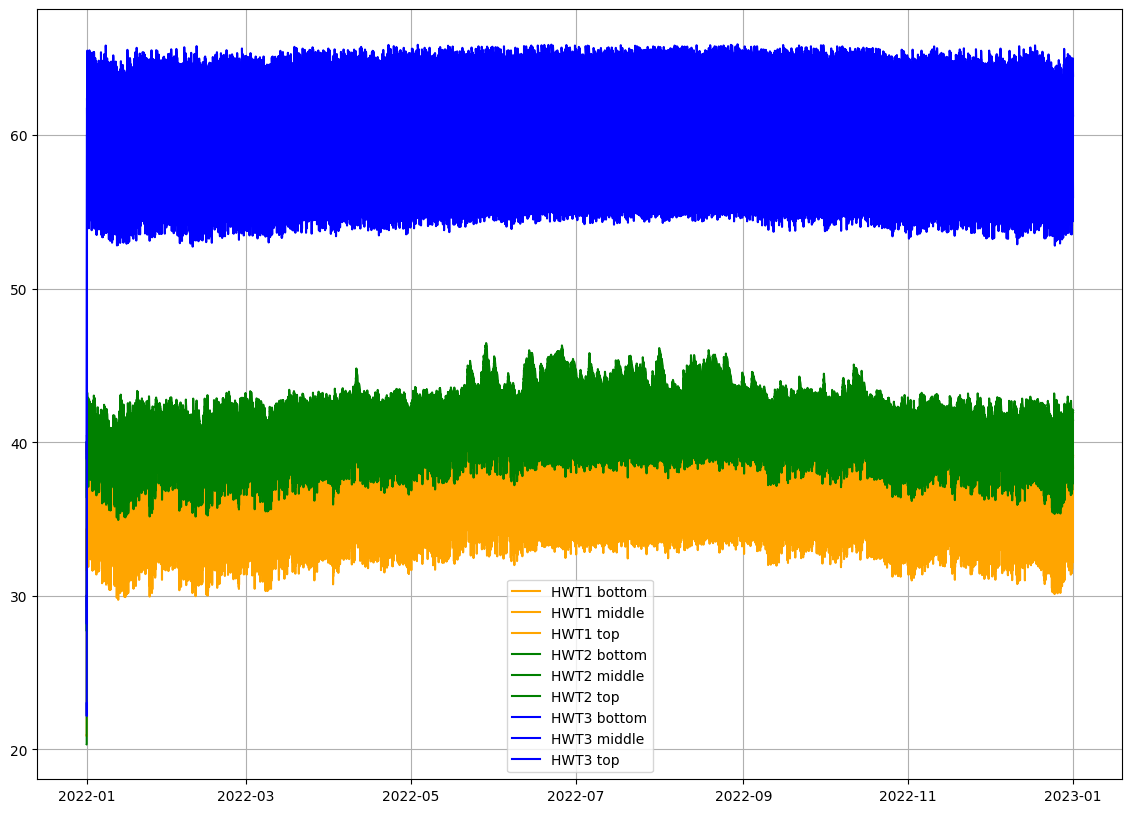

In [98]:
hwt1_cols = [col for col in df.columns if col.startswith('HotWaterTankSim-0.HotWaterTank_0-sensor')]
hwt2_cols = [col for col in df.columns if col.startswith('HotWaterTankSim-1.HotWaterTank_0-sensor')]
hwt3_cols = [col for col in df.columns if col.startswith('HotWaterTankSim-2.HotWaterTank_0-sensor')]

plt.figure(figsize=(14, 10))
plt.plot(df[hwt1_cols], label=['HWT1 bottom', 'HWT1 middle', 'HWT1 top'], color = 'orange')
plt.plot(df[hwt2_cols], label=['HWT2 bottom', 'HWT2 middle', 'HWT2 top'], color = 'green')
plt.plot(df[hwt3_cols], label=['HWT3 bottom', 'HWT3 middle', 'HWT3 top'], color = 'blue')

plt.grid()
plt.legend()
plt.show()

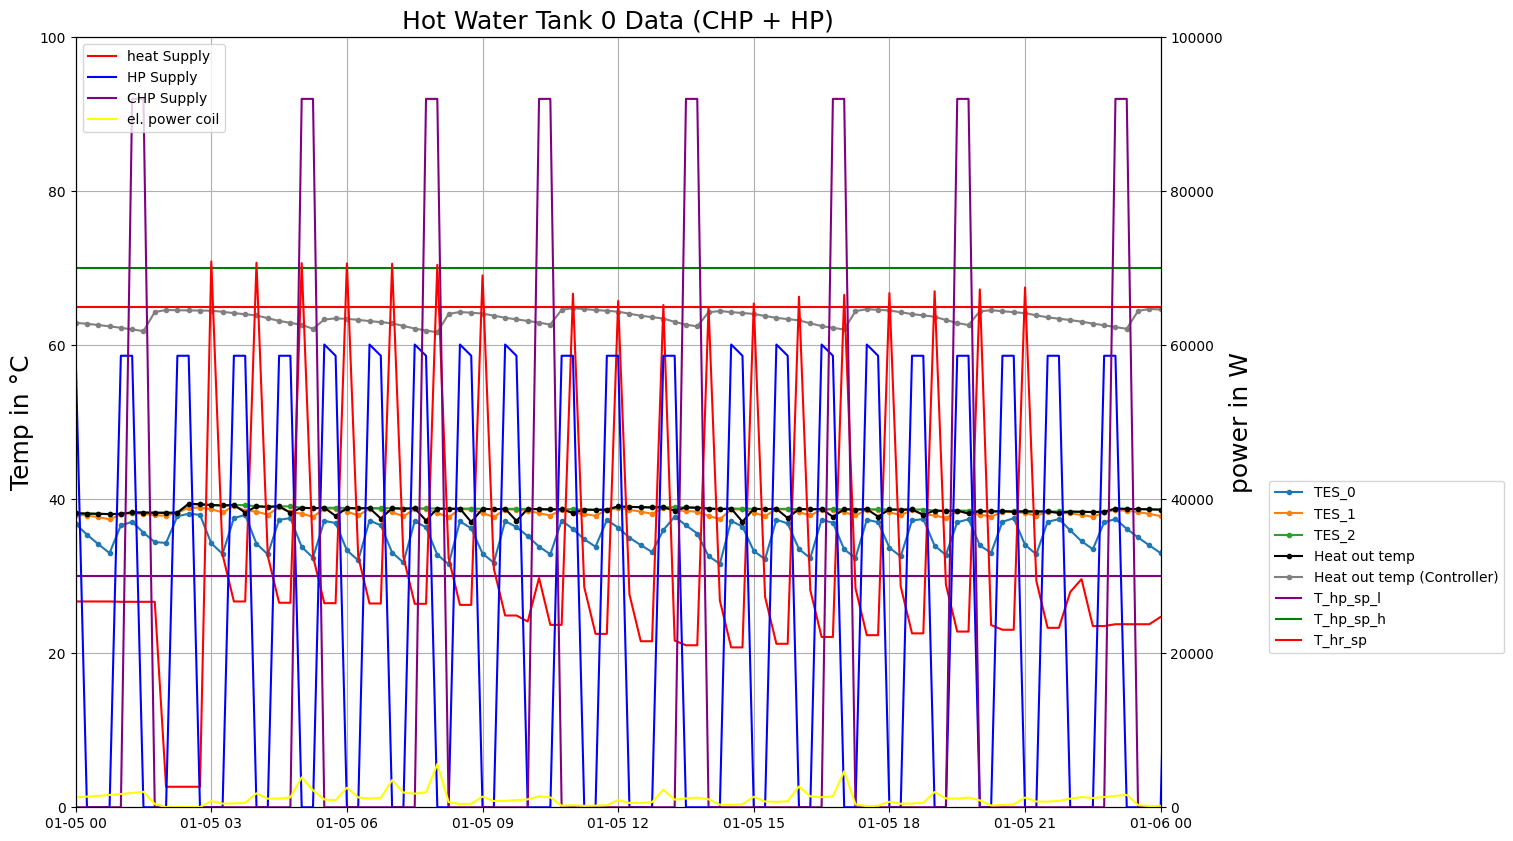

In [99]:
params_ctrl = {
    'T_hp_sp_h': 70,
    'T_hp_sp_l': 30,
    'T_hr_sp': 65,
    'operation_mode': 'heating',
    'control_strategy': '3'
}

hot_water_tank_columns = [col for col in df.columns if col.startswith('HotWaterTankSim-0.HotWaterTank_0-sensor')]

plt.figure(figsize=(14, 10))

# Plotting the hot water tank data
plt.plot(df[hot_water_tank_columns], label=['TES_0', 'TES_1', 'TES_2'], marker='.')
plt.plot(df['HotWaterTankSim-0.HotWaterTank_0-heat_out.T'], color='black', label='Heat out temp', marker='.')
plt.plot(df['ControllerSim-0.Controller_0-heat_out_T'], color='grey', label='Heat out temp (Controller)', marker='.')

# Plotting horizontal lines
plt.hlines(params_ctrl['T_hp_sp_l'], 1000, 9999999, label='T_hp_sp_l', color='purple')
plt.hlines(params_ctrl['T_hp_sp_h'], 1000, 9999999, label='T_hp_sp_h', color='green')
plt.hlines(params_ctrl['T_hr_sp'], 1000, 9999999, label='T_hr_sp', color='red')


# Primary y-axis
plt.ylabel('Temp in °C', fontsize=18)
plt.title('Hot Water Tank 0 Data (CHP + HP)', fontsize=18)
plt.grid()
plt.xlim([datetime.date(2022, 1, 5), datetime.date(2022, 1, 6)])
plt.ylim(0,100)
plt.legend(loc=(1.1, 0.2))

# Create secondary y-axis for sh_demand
ax2 = plt.gca().twinx()
ax2.plot(df.index, df['ControllerSim-0.Controller_0-heat_demand'], color='red', label='heat Supply')
ax2.plot(df.index, df['ControllerSim-0.Controller_0-hp_supply'], color='blue', label='HP Supply')
ax2.plot(df.index, df['ControllerSim-0.Controller_0-chp_supply'], color='purple', label='CHP Supply')
ax2.plot(df.index, df['ControllerSim-0.Controller_0-P_hr'], color='yellow', label='el. power coil')
ax2.set_ylabel('power in W', fontsize=18)
ax2.tick_params(axis='y')
ax2.set_ylim(0,100_000)

# Combining legends from both axes
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(labels + labels2, loc='upper left')

plt.show()

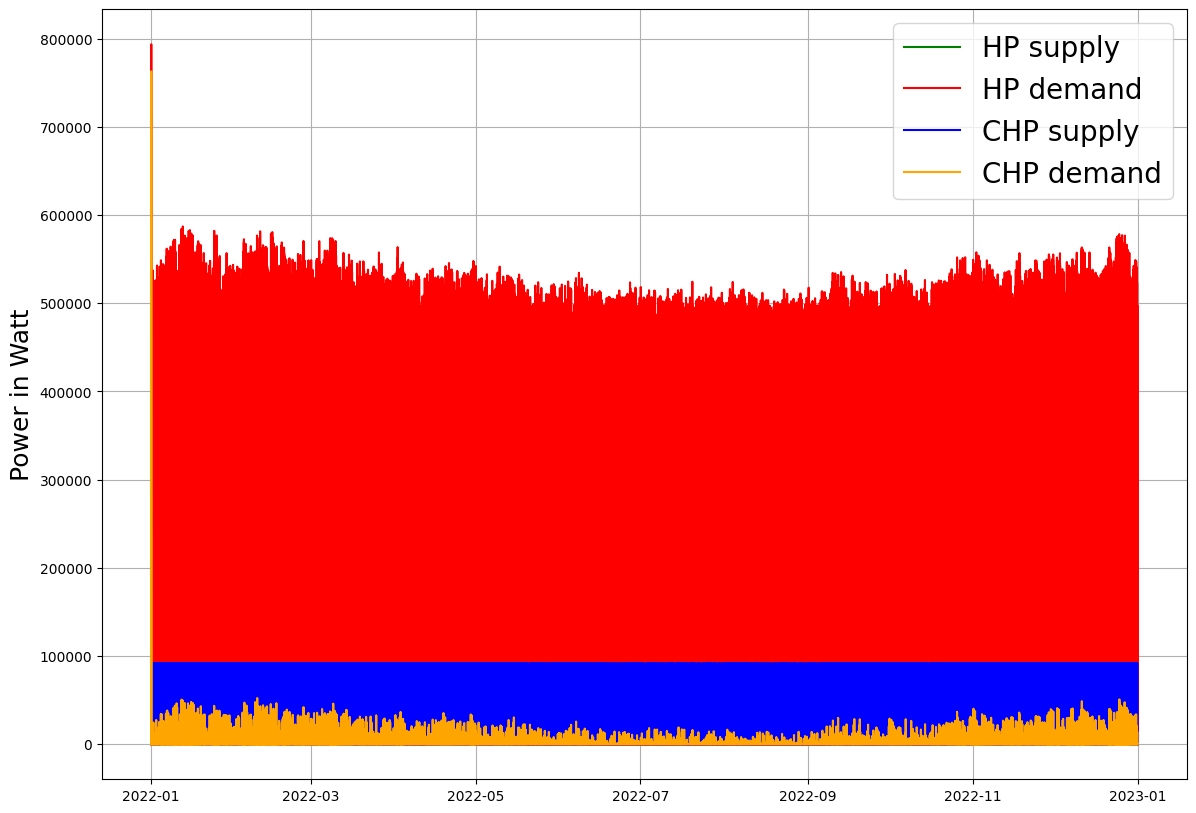

In [100]:
plt.figure(figsize=(14, 10))
# plt.plot(df['ControllerSim-0.Controller_0-heat_supply'], color='blue', label='heat supply')
plt.plot(df['ControllerSim-0.Controller_0-hp_supply'], color='green', label='HP supply')
plt.plot(df['ControllerSim-0.Controller_0-hp_demand'], color='red', label='HP demand')
plt.plot(df['ControllerSim-0.Controller_0-chp_supply'], color='blue', label='CHP supply')
plt.plot(df['ControllerSim-0.Controller_0-chp_demand'], color='orange', label='CHP demand')

# plt.plot(df['CHPSim-0.CHP_0-Q_Demand'], color='red', label='CHP demand')
# plt.yticks(fontsize=20)
plt.ylabel('Power in Watt', fontsize=18)
# plt.title('Energy flows', fontsize=30, y=1.05)
plt.grid()
plt.legend(fontsize=20)
plt.show()

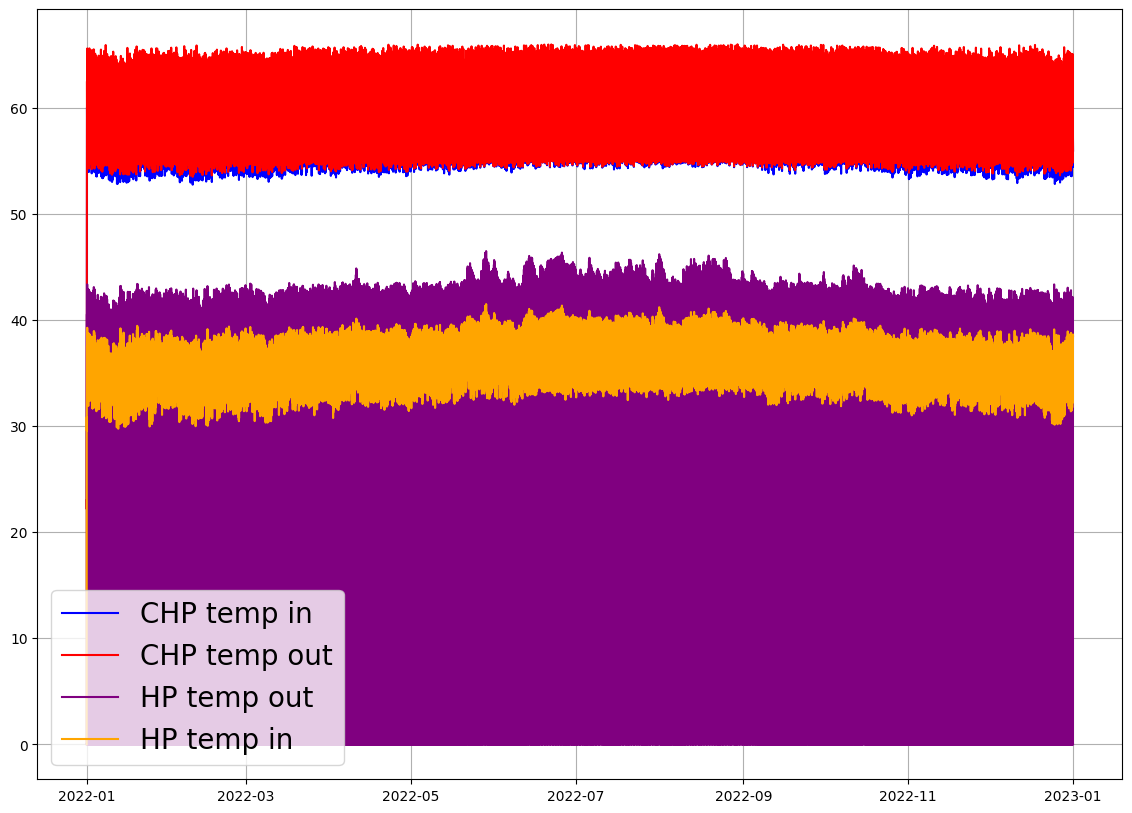

In [101]:
plt.figure(figsize=(14, 10))
plt.plot(df['CHPSim-0.CHP_0-temp_in'], color='blue', label='CHP temp in')
plt.plot(df['CHPSim-0.CHP_0-temp_out'], color='red', label='CHP temp out')
plt.plot(df['HeatPumpSim-0.HeatPump_0-cons_T'], color='purple', label='HP temp out')
plt.plot(df['HeatPumpSim-0.HeatPump_0-cond_in_T'], color='orange', label='HP temp in')

plt.grid()
plt.legend(fontsize=20)
plt.show()

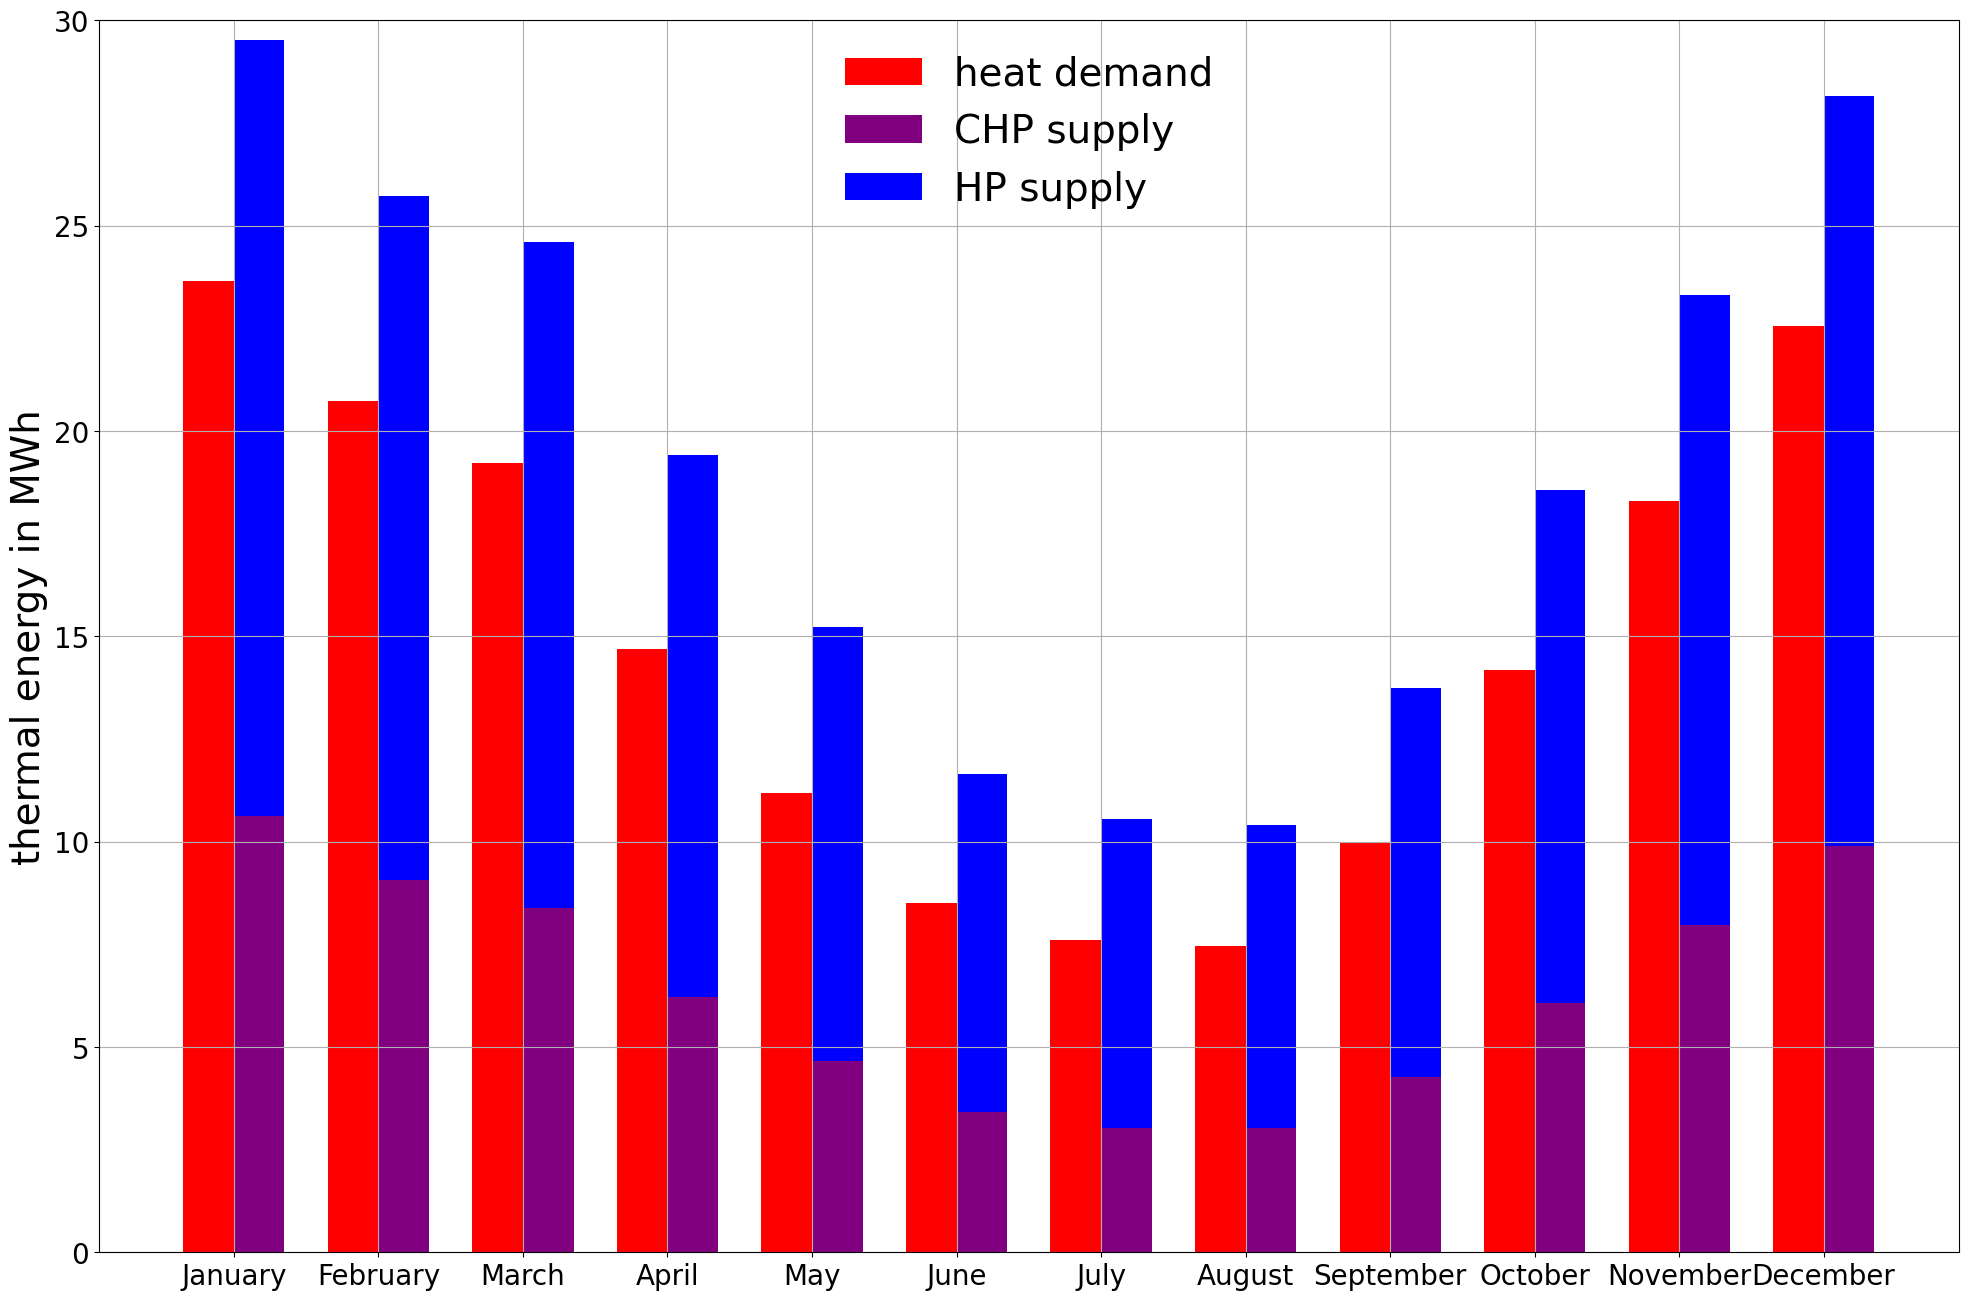

In [102]:
df_monthly = df.resample('M').sum()/4

# Generate the positions for the bars
months = df_monthly.index.month_name()
x = np.arange(len(months))  # the label locations
width = 0.35  # the width of the bars

# Create the figure and the bar plots
plt.figure(figsize=(24, 16))

# Plot heat demand on the left
plt.bar(
    x - width/2, 
    df_monthly['ControllerSim-0.Controller_0-heat_demand']/1_000_000, 
    width=width, 
    color='red', 
    label='heat demand', 
)

# Plot CHP supply stacked with HP supply on the right
plt.bar(
    x + width/2, 
    df_monthly['ControllerSim-0.Controller_0-chp_supply']/1_000_000, 
    width=width, 
    color='purple', 
    label='CHP supply', 
)
plt.bar(
    x + width/2, 
    df_monthly['ControllerSim-0.Controller_0-hp_supply']/1_000_000, 
    width=width, 
    color='blue', 
    label='HP supply', 
    bottom=df_monthly['ControllerSim-0.Controller_0-chp_supply']/1_000_000
)

# Set x-ticks and labels
plt.xticks(x, months, fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('thermal energy in MWh', fontsize=28)
plt.ylim(0,30)
plt.grid()

# Set the legend
plt.legend(fontsize=28, frameon=False)

# Display the plot
plt.show()

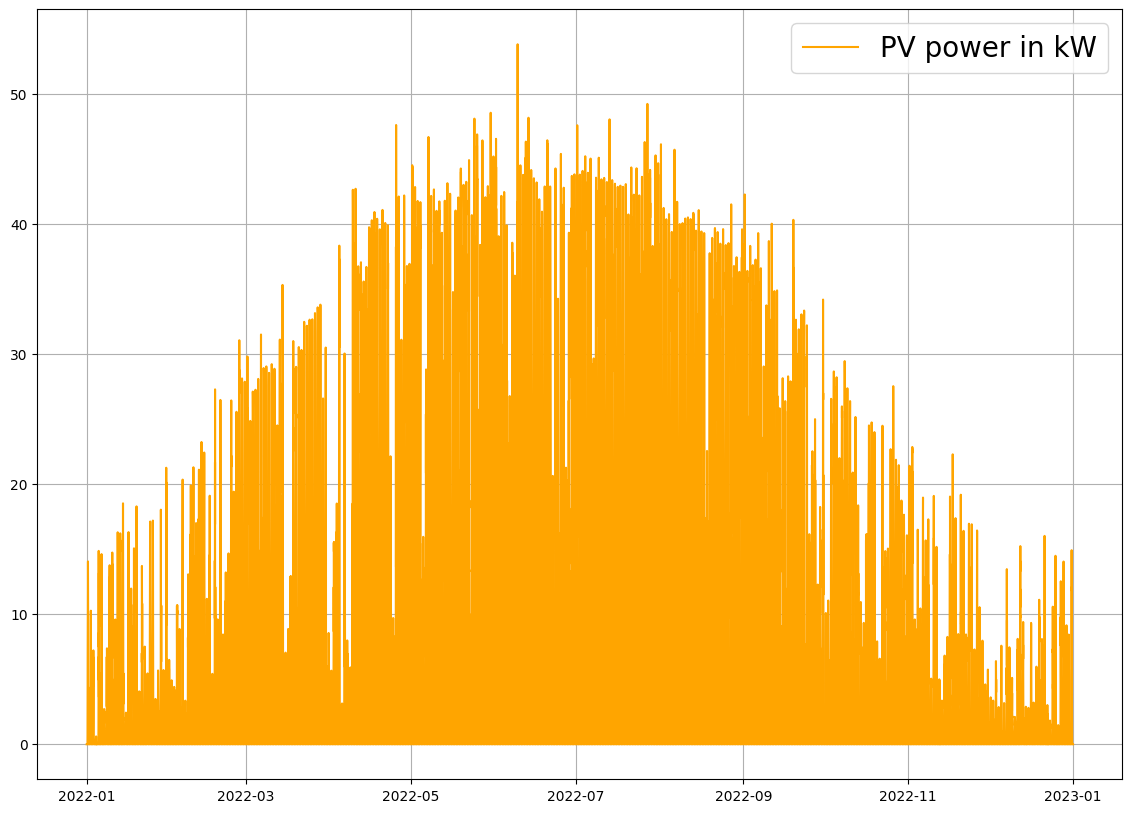

In [103]:
plt.figure(figsize=(14, 10))

plt.plot(df['PVSim-0.PV_0-P[MW]']*1000, color='orange', label='PV power in kW')
# plt.title('Energy flows', fontsize=30, y=1.05)
plt.grid()
plt.legend(fontsize=20)
plt.show()


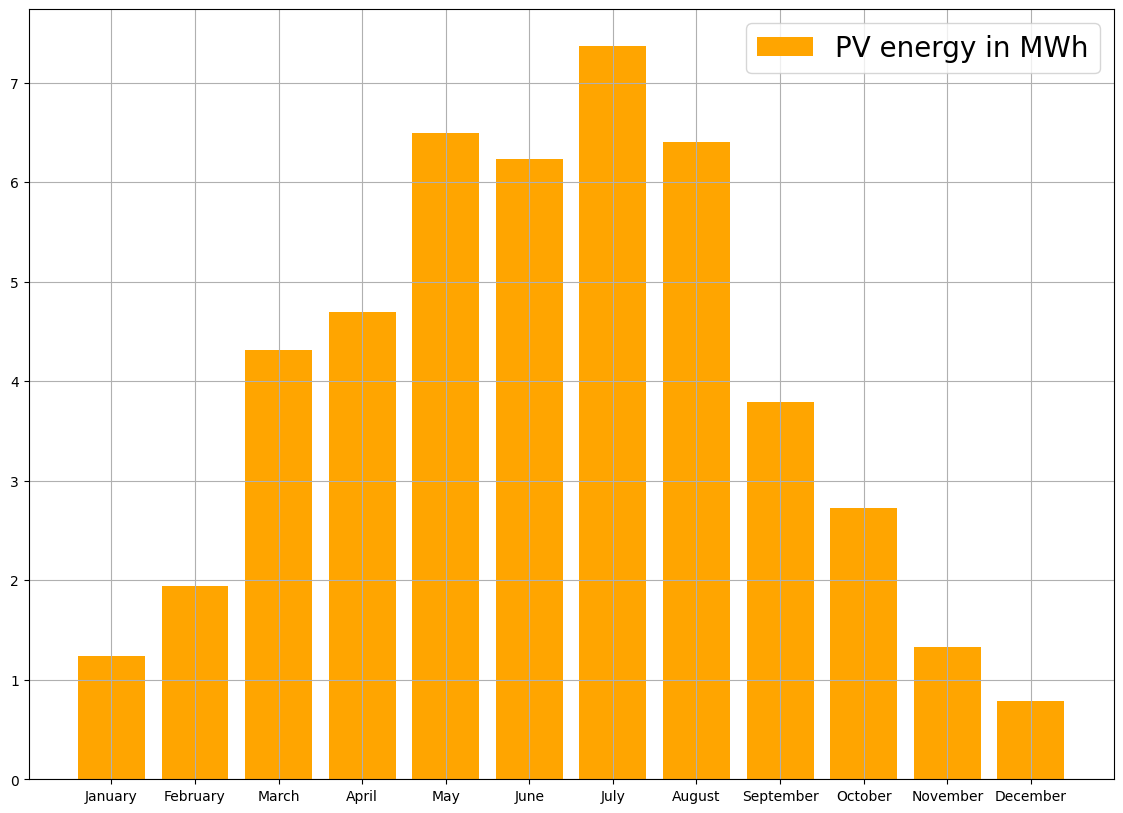

In [104]:
plt.figure(figsize=(14, 10))

plt.bar(months, df_monthly['PVSim-0.PV_0-P[MW]'], color='orange', label='PV energy in MWh')
# plt.title('Energy flows', fontsize=30, y=1.05)
plt.grid()
plt.legend(fontsize=20)
plt.show()

In [105]:
columnname = {'PVSim-0.PV_0-P[MW]': 'PV_P[MW]', 'CSV-0.DNI_0-DNI': 'DNI', 'CSV-1.HEATLOAD_0-T_amb':'T_amb', 'HeatPumpSim-0.HeatPump_0-T_amb' : 'HP_Tamb', 'CSV-1.HEATLOAD_0-Heat Demand [kW]':'Heat Demand [KW]',
       'HeatPumpSim-0.HeatPump_0-Q_Demand' : 'HP_Q_Demand', 'CHPSim-0.CHP_0-Q_Demand':'CHP_Q_Demand',
       'HeatPumpSim-0.HeatPump_0-Q_Supplied' : 'HP_Q_Supplied',
       'HeatPumpSim-0.HeatPump_0-heat_source_T' : 'HP_heat_sourceT',
       'HeatPumpSim-0.HeatPump_0-cons_T' : 'HP_consT',
       'HeatPumpSim-0.HeatPump_0-P_Required': 'HP_P_Required', 'HeatPumpSim-0.HeatPump_0-COP':'HP_COP',
       'HeatPumpSim-0.HeatPump_0-cond_m':'HP_cond_m', 'HeatPumpSim-0.HeatPump_0-cond_in_T':'HP_cond_in_T',
       'HeatPumpSim-0.HeatPump_0-on_fraction':'HP_onfraction',
       'ControllerSim-0.Controller_0-heat_demand':'heat_demand',
       'ControllerSim-0.Controller_0-heat_supply':'heat_supply',
       'ControllerSim-0.Controller_0-hp_demand':'hp_demand',
       'ControllerSim-0.Controller_0-hp_supply':'hp_supply',
       'ControllerSim-0.Controller_0-chp_demand':'chp_demand',
       'ControllerSim-0.Controller_0-chp_supply':'chp_supply',
       'ControllerSim-0.Controller_0-heat_in_F':'heatin_F',
       'ControllerSim-0.Controller_0-heat_in_T':'heatin_T',
       'ControllerSim-0.Controller_0-heat_out_F':'heatout_F',
       'ControllerSim-0.Controller_0-heat_out_T':'heatout_T',
       'ControllerSim-0.Controller_0-chp_in_F':'chpin_F',
       'ControllerSim-0.Controller_0-chp_in_T':'chpin_T',
       'ControllerSim-0.Controller_0-chp_out_F':'chpout_F',
       'ControllerSim-0.Controller_0-chp_out_T':'chpout_T',
       'ControllerSim-0.Controller_0-hp_out_F':'hpout_F',
       'ControllerSim-0.Controller_0-hp_out_T':'hpout_T',
       'ControllerSim-0.Controller_0-P_hr':'P_hr',
       'HotWaterTankSim-0.HotWaterTank_0-sensor_00.T':'HWTSim0_sensor0_T',
       'HotWaterTankSim-1.HotWaterTank_0-sensor_00.T':'HWTSim1_sensor0_T',
       'HotWaterTankSim-2.HotWaterTank_0-sensor_00.T':'HWTSim2_sensor0_T',
       'HotWaterTankSim-0.HotWaterTank_0-sensor_01.T':'HWTSim0_sensor1_T',
       'HotWaterTankSim-1.HotWaterTank_0-sensor_01.T':'HWTSim1_sensor1_T',
       'HotWaterTankSim-2.HotWaterTank_0-sensor_01.T':'HWTSim2_sensor1_T',
       'HotWaterTankSim-0.HotWaterTank_0-sensor_02.T':'HWTSim0_sensor2_T',
       'HotWaterTankSim-1.HotWaterTank_0-sensor_02.T':'HWTSim1_sensor2_T',
       'HotWaterTankSim-2.HotWaterTank_0-sensor_02.T':'HWTSim2_sensor2_T',
       'HotWaterTankSim-0.HotWaterTank_0-heat_out.T':'HWTSim0_heatout_T',
       'HotWaterTankSim-1.HotWaterTank_0-heat_out.T':'HWTSim1_heatout_T',
       'HotWaterTankSim-2.HotWaterTank_0-heat_out.T':'HWTSim2_heatout_T',
       'HotWaterTankSim-0.HotWaterTank_0-heat_out.F':'HWTSim0_heatout_F',
       'HotWaterTankSim-1.HotWaterTank_0-heat_out.F':'HWTSim1_heatout_F',
       'HotWaterTankSim-2.HotWaterTank_0-heat_out.F':'HWTSim2_heatout_F',
       'HotWaterTankSim-0.HotWaterTank_0-hp_in.T':'HWTSim0_hp_in_T',
       'HotWaterTankSim-1.HotWaterTank_0-hp_in.T':'HWTSim1_hp_in_T',
       'HotWaterTankSim-2.HotWaterTank_0-hp_in.T':'HWTSim2_hp_in_T',
       'HotWaterTankSim-0.HotWaterTank_0-hp_in.F':'HWTSim0_hp_in_F',
       'HotWaterTankSim-1.HotWaterTank_0-hp_in.F':'HWTSim1_hp_in_F',
       'HotWaterTankSim-2.HotWaterTank_0-hp_in.F':'HWTSim2_hp_in_F',
       'HotWaterTankSim-0.HotWaterTank_0-hp_out.T':'HWTSim0_hp_out_T',
       'HotWaterTankSim-1.HotWaterTank_0-hp_out.T':'HWTSim1_hp_out_T',
       'HotWaterTankSim-2.HotWaterTank_0-hp_out.T':'HWTSim2_hp_out_T',
       'HotWaterTankSim-0.HotWaterTank_0-hp_out.F':'HWTSim0_hp_out_F',
       'HotWaterTankSim-1.HotWaterTank_0-hp_out.F':'HWTSim1_hp_out_F',
       'HotWaterTankSim-2.HotWaterTank_0-hp_out.F':'HWTSim2_hp_out_F',
       'HotWaterTankSim-0.HotWaterTank_0-heat_in.T':'HWTSim0_heatin_T',
       'HotWaterTankSim-1.HotWaterTank_0-heat_in.T':'HWTSim1_heatin_T',
       'HotWaterTankSim-2.HotWaterTank_0-heat_in.T':'HWTSim2_heatin_T',
       'HotWaterTankSim-0.HotWaterTank_0-heat_in.F':'HWTSim0_heatin_F',
       'HotWaterTankSim-1.HotWaterTank_0-heat_in.F':'HWTSim1_heatin_F',
       'HotWaterTankSim-2.HotWaterTank_0-heat_in.F':'HWTSim2_heatin_F',
       'HotWaterTankSim-0.HotWaterTank_0-T_mean':'HWTSim0_Tmean',
       'HotWaterTankSim-1.HotWaterTank_0-T_mean':'HWTSim1_Tmean',
       'HotWaterTankSim-2.HotWaterTank_0-T_mean':'HWTSim2_Tmean', 'CHPSim-0.CHP_0-eff_el':'CHP_eff',
       'CHPSim-0.CHP_0-nom_P_th':'CHP_nom_Pth', 'CHPSim-0.CHP_0-mdot':'CHP_mdot',
       'CHPSim-0.CHP_0-mdot_neg':'CHP_mdot_neg', 'CHPSim-0.CHP_0-temp_in':'CHP_tempin',
       'CHPSim-0.CHP_0-temp_out':'CHP_tempout', 'CHPSim-0.CHP_0-P_th':'CHP_Pth'}

In [106]:
oldcolumns = df.columns
column_translate = np.asarray(list(columnname.keys()))

n = np.setdiff1d(oldcolumns,column_translate)  
print(f'translation not defined for :\n {n}') 

df.rename(columns = columnname, inplace = True)
# df.head()
print(f'{len(df.columns)-len(columnname.keys())} columns were not translated!')

columnnew = df.columns
targetcolumn = np.asarray(list(columnname.values()))
for i,j in zip(columnnew, targetcolumn):
    if not i == j:

        print(f'{j} not translated\n')

translation not defined for :
 ['CHPSim-0.CHP_0-P_el']
1 columns were not translated!
